In [9]:
import sys
import os
import skimage.io
from skimage.transform import resize
import cv2
import json

#os.chdir('Mask_RCNN')
print(os.getcwd())
print(sys.path)
sys.path.append(r"C:\Users\Isabell\master_projet_2\Mask_RCNN")

from mrcnn import utils
from mrcnn.utils import Dataset
print("done one")
from mrcnn.model import log
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.config import Config


COCO_MODEL_PATH = r'C:\Users\Isabell\master_projet_2\Data\pretrained_weights.h5'

sys.path.append(r"C:\Users\Isabell\master_projet_2\Mask_RCNN\samples\coco")  # To find local version

print(sys.path)

import coco

c:\Users\Isabell\master_projekt\waermelyse\machine_learning\roof_indentification\Mask_RCNN
['c:\\Users\\Isabell\\master_projekt\\waermelyse\\machine_learning\\roof_indentification', 'C:\\Users\\Isabell\\AppData\\Local\\Programs\\Python\\Python37\\python37.zip', 'C:\\Users\\Isabell\\AppData\\Local\\Programs\\Python\\Python37\\DLLs', 'C:\\Users\\Isabell\\AppData\\Local\\Programs\\Python\\Python37\\lib', 'C:\\Users\\Isabell\\AppData\\Local\\Programs\\Python\\Python37', 'c:\\Users\\Isabell\\master_projekt\\waermelyse\\.venv37', '', 'c:\\Users\\Isabell\\master_projekt\\waermelyse\\.venv37\\lib\\site-packages', 'c:\\Users\\Isabell\\master_projekt\\waermelyse\\.venv37\\lib\\site-packages\\win32', 'c:\\Users\\Isabell\\master_projekt\\waermelyse\\.venv37\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Isabell\\master_projekt\\waermelyse\\.venv37\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Isabell\\master_projekt\\waermelyse\\.venv37\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Isabell\

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320   
config = InferenceConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
ROOT_DIR = r"C:\Users\Isabell\master_projet_2"
print("loading mask R-CNN model")
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=ROOT_DIR)
#-------------- Load weights trained on MS-COCO -------------------------------
model.load_weights(COCO_MODEL_PATH, by_name=True)
# Access the internal Keras model and print its summary
model.keras_model.summary()

loading mask R-CNN model






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
________________________________________________________

Processing 1 images
image                    shape: (300, 300, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -104.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


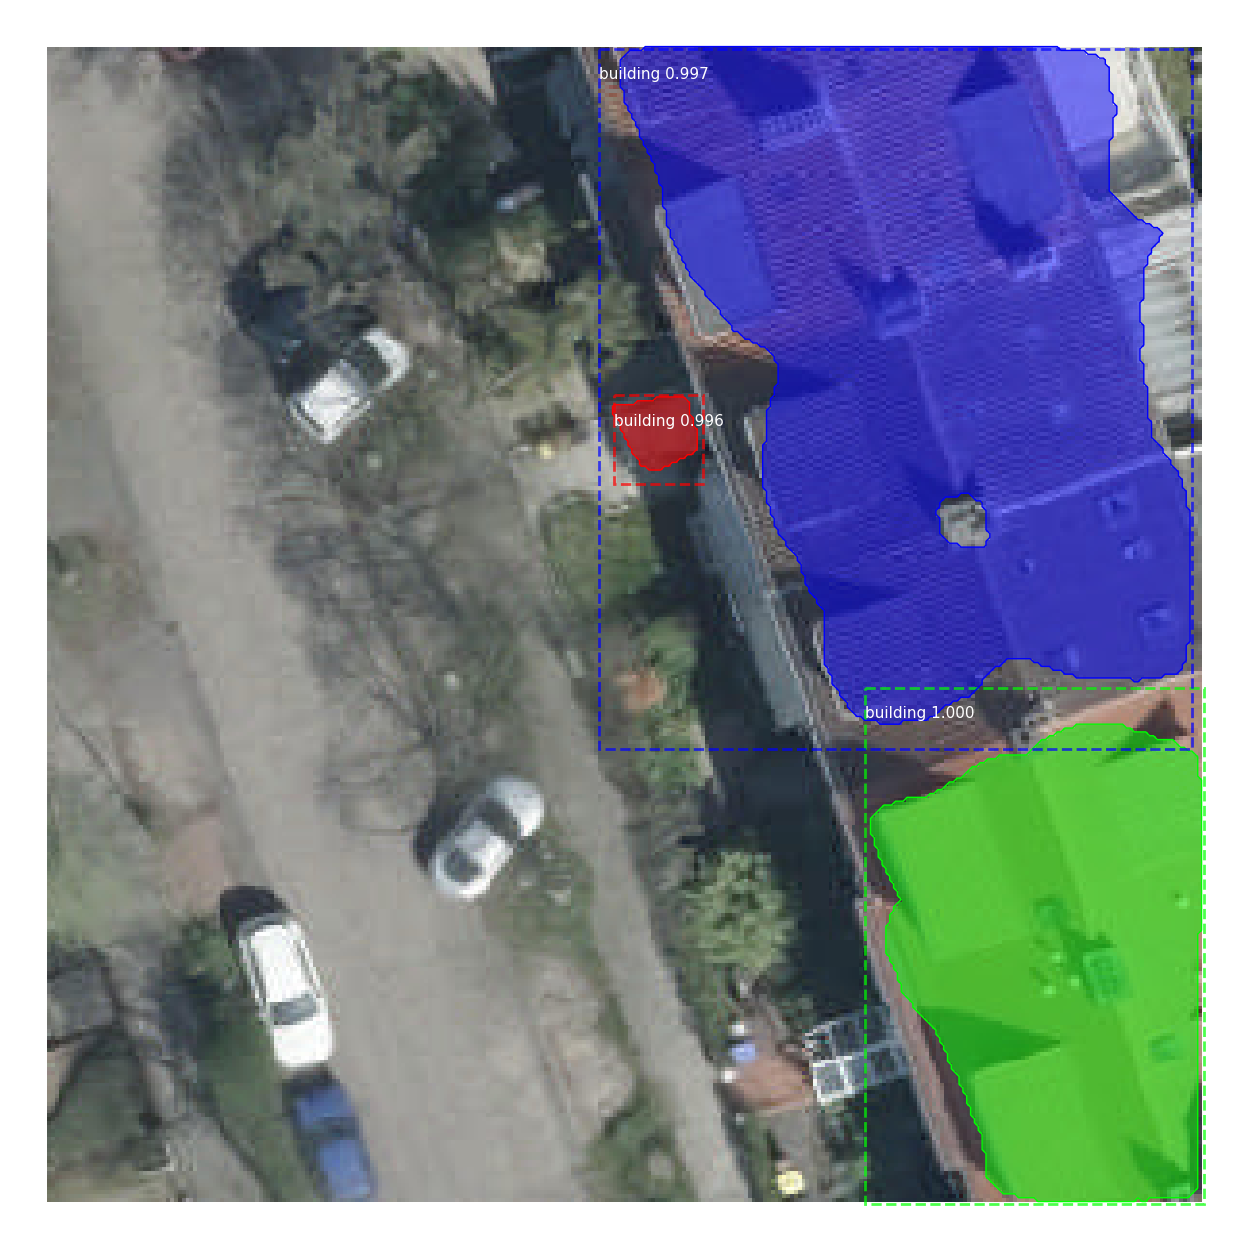

In [4]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building
#file_names = next(os.walk(IMAGE_DIR))[2]

image_path = r"C:\Users\Isabell\master_projet_2\Data\tile_489476_5881989_highres.jpg"

random_image = skimage.io.imread(image_path)
resized_image = cv2.resize(random_image, (300, 300))

predictions = model.detect([resized_image]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]
visualize.display_instances(resized_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])

# Transfer Learning

### Loading and preparing data

In [ ]:
class CustomDataset(Dataset):
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the dataset."""
        # Add classes: 0 for background, 1 for roof, 2 for tree
        self.add_class("object", 1, "Dächer")  # Roof
        self.add_class("object", 2, "Bäume")   # Tree

        # Load annotations from the JSON file
        annotations_path = os.path.join(dataset_dir, subset, "annotations.json")
        with open(annotations_path) as f:
            coco = json.load(f)

        # Add images and their annotations
        for image_info in coco["images"]:
            image_id = image_info["id"]
            self.add_image(
                "object",  # This is the dataset name, could be "object" for general object detection
                image_id=image_id,
                path=os.path.join(dataset_dir, subset, "images", image_info["file_name"]),
                width=image_info["width"],
                height=image_info["height"],
                annotations=[
                    ann for ann in coco["annotations"] if ann["image_id"] == image_id
                ]
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image."""
        # Get the annotations for the image
        annotations = self.image_info[image_id]["annotations"]
        masks = []
        class_ids = []
        for annotation in annotations:
            # Decode the segmentation (polygon or RLE)
            mask = self.decode_coco_rle(annotation["segmentation"])
            masks.append(mask)
            class_ids.append(annotation["category_id"])  # 1 for roof, 2 for tree
        
        masks = np.stack(masks, axis=-1)  # Stack masks for multiple objects
        return masks, np.array(class_ids, dtype=np.int32)

    def decode_coco_rle(self, rle):
        """Decode RLE or polygon segmentation to a mask."""
        from mrcnn.utils import shapely
        mask = shapely.geometry.Polygon(rle).buffer(0).convex_hull
        return mask

### Loading Model

In [ ]:
model = modellib.MaskRCNN(mode="training", config=TrainingConfig(), model_dir=ROOT_DIR)

# Load COCO pre-trained weights
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"
])

### Freeze first layers

In [ ]:
# Freeze specific layers
for layer in model.keras_model.layers:
    if "conv1" in layer.name or "conv2" in layer.name or "conv3" in layer.name:
        layer.trainable = False  # Freeze early layers (low-level features)
    else:
        layer.trainable = True  # Fine-tune the rest of the layers

### Modify Config Class

In [ ]:
class TrainingConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1  # Increase if GPU memory allows
    NUM_CLASSES = 1 + 1  # Background + 1 building !!! needs to be 3 if tree and roof detections simultaneously
    LEARNING_RATE = 1e-4
    STEPS_PER_EPOCH = 100  # Adjust based on dataset size
    VALIDATION_STEPS = 10

### Training Model

In [ ]:
model = modellib.MaskRCNN(mode="training", config=TrainingConfig(), model_dir=ROOT_DIR)

# Load COCO weights, excluding the last layers
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


In [ ]:
model.train(train_dataset, val_dataset,
            learning_rate=TrainingConfig.LEARNING_RATE,
            epochs=30,
            layers="heads") 

## Evaluation